In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import time
import torch
from feedforward import DQNAgent
import pylab as plt
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import hockey.hockey_env as h_env
print("hi")

hi


## Helper Functions

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [3]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins = 5):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)

    def action(self, action):
        """ discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.orig_action_space.low + action/(self.bins-1.0)*(self.orig_action_space.high-self.orig_action_space.low)  

## Test in Env

In [4]:
env_name = 'Pendulum-v1'
# # env_name = 'CartPole-v0'
env = gym.make(env_name)

# env = h_env.HockeyEnv()

if isinstance(env.action_space, spaces.Box):
    print("Discretizing actions")
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space


q_agent = DQNAgent(o_space, ac_space, eps=0.2, update_Qt_after=20)

Discretizing actions


In [5]:
print(ac_space)
print(o_space)

Discrete(5)
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


Train the agent!

In [6]:
stats = []
losses = []

max_episodes=600
max_steps=500 
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):      # fill buffer
        done = False        
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

1: Done after 500 steps. Reward: -4604.701931616069
21: Done after 500 steps. Reward: -2946.272795377937
41: Done after 500 steps. Reward: -3049.4533858515942
61: Done after 500 steps. Reward: -3443.221281519682
81: Done after 500 steps. Reward: -3441.899799185814
101: Done after 500 steps. Reward: -3306.3482612436637
121: Done after 500 steps. Reward: -3181.255106612291
141: Done after 500 steps. Reward: -2856.7620976765375
161: Done after 500 steps. Reward: -3101.4550221381796
181: Done after 500 steps. Reward: -1835.406560063662
201: Done after 500 steps. Reward: -534.4269713555007
221: Done after 500 steps. Reward: -256.2524852456588
241: Done after 500 steps. Reward: -768.2665985313829
261: Done after 500 steps. Reward: -2006.2528518259649
281: Done after 500 steps. Reward: -1878.9245703105971
301: Done after 500 steps. Reward: -2363.920794867448
321: Done after 500 steps. Reward: -4.670107503631812
341: Done after 500 steps. Reward: -1488.231566341107
361: Done after 500 steps. R

Plot the training reward over time. Use the running_mean(array, window_size) to plot a smooth version 

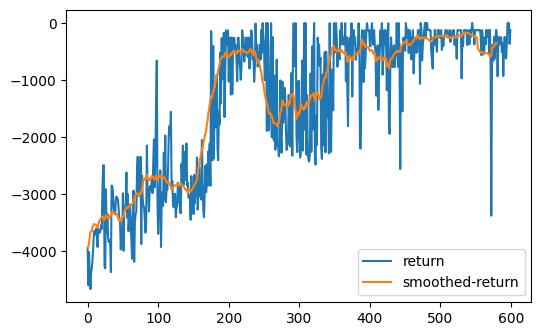

In [7]:
stats_np = np.asarray(stats)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

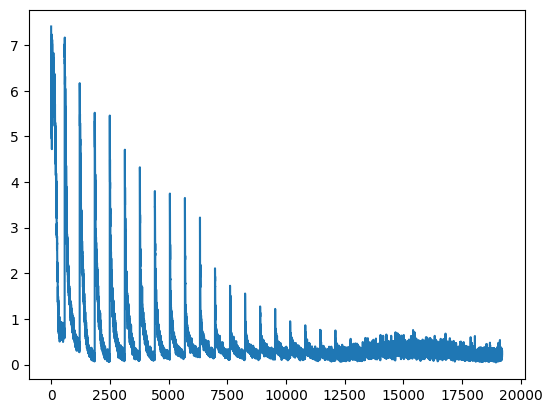

In [8]:
losses_np = np.asarray(losses)
plt.figure()
plt.plot(losses_np)

## Evaluate (without exploration)

Please look at the behavior for a small number of episodes

In [9]:
env_eval = gym.make(env_name, render_mode="human")
if isinstance(env.action_space, spaces.Box):
    env_eval = DiscreteActionWrapper(env_eval,5)

In [10]:
test_stats = []
episodes=50
env_ = env    # without rendering
#env_ = env_eval # with rendering

for i in range(episodes):
    total_reward = 0
    ob, _info = env_.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob, eps=0.0)
        (ob_new, reward, done, trunc, _info) = env_.step(a)
        total_reward+= reward
        ob=ob_new        
        if done: break    
    test_stats.append([i,total_reward,t+1])        

Evaluate mean and standard deviation of performance 

(for the Pendulum: an average return around -30 or better should be achieved)

(for the CartPendulum it is possible to get 200)

In [11]:
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))

-293.52390155407176 +- 913.8096535438326


# Visualize

Visualization of the value function.

In [ ]:
Adapt the value_function plotting from last time to plot the maxQ value

## Pendulum Env

Observation space:

0 angle

1 angular velocity

Do that for the pendulum function. Does it look like you expect?

Do that for the pendulum function. Does it look like you expect

## Cartpole Env

Observation space:
 
0       Cart Position             -4.8                    4.8

1       Cart Velocity             -Inf                    Inf

2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)

3       Pole Angular Velocity     -Inf                    Inf

Try to adapt the plotting function that it also works in higher input spaces where all other inputs are 0

In [ ]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=2, 
                       label_dim1="Cart Pos", label_dim2="Pole Angle")

In [ ]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=1, 
                       label_dim1="Cart Pos", label_dim2="Cart Vel")

In [ ]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=2, plot_dim2=3, 
                       label_dim1="Pol Angle", label_dim2="Pole Vel")

In [ ]:
# env_name = 'Acrobot-v1'
# env_name = 'MountainCar-v0'
# env_name = 'LunarLander-v2'